In [47]:
import pickle
import pandas as pd
import urllib.request
import json
import math 
import ast
import re
from itertools import islice
from urllib.parse import quote 

In [12]:
# 1. Load names/wiki links dictionary
def extractDataFiles(filename):
    marvel = pd.read_csv(filename +".csv")
    marvel_wikilinks = marvel.loc[:, 'WikiLink']
    marvel_characters = marvel_wikilinks[marvel_wikilinks.notna()].to_numpy()

    all_marvel = {}

    for name in marvel_characters:
        character = name.replace(" ", "_")
        all_marvel[character] = character

    return all_marvel

In [21]:
# 1. calling the functions
marvel = extractDataFiles('marvel')
dc = extractDataFiles('dc')

In [22]:
# 3. create URL with given character_wiki_link
# @returns NAME-> URL dict
def createURLs(data_dir): 
    
    url_query_list = {}
    
    for name,wiki in data_dir.items():        
        baseurl = "https://en.wikipedia.org/w/api.php?"
        action = "action=query"
        title = "titles=" + wiki
        content = "prop=revisions&rvprop=content"
        only_links = "prop=links&pllimit=max"
        dataformat ="format=json"
        
        query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, title,only_links, dataformat)
        url_query_list[name] = query
        
    
    return url_query_list

url_query_directory = createURLs(marvel)


In [36]:
DC_url_query_directory = createURLs(dc)
print(DC_url_query_directory)

{'Abin_Sur': 'https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=Abin_Sur&prop=links&pllimit=max&format=json', 'Abra_Kadabra_(character)': 'https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=Abra_Kadabra_(character)&prop=links&pllimit=max&format=json', 'Abby_Holland': 'https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=Abby_Holland&prop=links&pllimit=max&format=json', 'Ace_the_Bat-Hound': 'https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=Ace_the_Bat-Hound&prop=links&pllimit=max&format=json', 'Adam_Strange': 'https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=Adam_Strange&prop=links&pllimit=max&format=json', 'Agent_Liberty': 'https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=Agent_Liberty&prop=links&pllimit=max&format=json', 'Air_Wave': 'https://en.wikipedia.org/w/api.php?action=quer

In [16]:
# 3.1 create URL with given character_wiki_link
# @returns NAME-> URL dict
def createURLsPages(data_dir): 
    
    url_query_list = {}
    
    for name,wiki in data_dir.items():
        
        character_wiki_link = data_dir[name]
        
        baseurl = "https://en.wikipedia.org/w/api.php?"
        action = "action=query"
        title = "titles=" + character_wiki_link
        content = "prop=revisions&rvprop=content"
        only_links = ""
        dataformat ="format=json"
        
        query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, title,only_links, dataformat)
        url_query_list[name] = query
        
    
    return url_query_list

url_query_directory_pages = createURLsPages(marvel)

In [23]:
# 4. Send request

def sendWikiRequests(url_list):
    response_wiki_dir = {}
    #z = list(url_list.values())[1]
    #name =  list(url_list.keys())[1]
    
    for name,url in url_list.items():
        #'ascii' codec can't encode character
       ## if 'ñ'in url:
         #   continue
        try:
            wikiresponse = urllib.request.urlopen(url)
            wikidata = wikiresponse.read()
            #print(wikidata)
            wikitext = wikidata.decode('utf-8')
        
        #if (wikitext.strip().startswith("<!DOCTYPE html>")):
            #continue
        
            wiki_json = json.loads(wikitext)
            response_wiki_dir[name] = wiki_json
        except:
            pass
        
    return response_wiki_dir

wiki_json_responses = sendWikiRequests(url_query_directory)

In [37]:
DC_wiki_json_responses = sendWikiRequests(DC_url_query_directory)

In [ ]:
# 4.1 Send request for full pages 

def sendWikiRequestsPages(url_list):
    response_wiki_dir = {}
    
    for name,url in url_list.items():
        print(url)
        
        try:
            response = requests.get(url)
            wikisource = response.json()
            pages = wikisource['query']['pages']
            
            for page in pages.keys():
                wikitext = pages[page]['revisions'][0]["*"]   
            print(type(wikitext))
            response_wiki_dir[name] = wikitext
        except:
            pass
        
    return response_wiki_dir

wiki_responses_pages = sendWikiRequestsPages(url_query_directory_pages)
print(wiki_responses)


In [33]:
# Save to file
import os.path

def saveWikiJsonFiles(name_wiki,universe):
    for name,wiki in name_wiki.items():
        
        save_path = str(universe)+'/'
        name = name.replace('|','')
        completeName = os.path.join(save_path, name+".txt")      
        try:
            with open(completeName, "w") as text_file:
                    text_file.write(str(wiki))
        except:
            pass        

In [34]:
saveWikiJsonFiles(wiki_json_responses, 'marvel')

In [38]:
saveWikiJsonFiles(DC_wiki_json_responses, 'dc')

# Part B: Building the networks


In [45]:
def readWikiJsonFiles(name_wiki,universe):
    
    name_wiki_json = {}
    
    for name,wiki in name_wiki.items():
        temp = []
        save_path = str(universe)+'/'
        completeName = os.path.join(save_path, name+".txt") 
        try:
            with open(completeName, "r") as text_file:
                f = text_file.read()
                name_wiki_json[name] = json.loads(json.dumps(f))
        except:
            pass
    
    return name_wiki_json


In [46]:
marvel_name_wiki = readWikiJsonFiles(wiki_json_responses, 'marvel')
DC_name_wiki = readWikiJsonFiles(DC_wiki_json_responses, 'dc')



In [87]:

# 5. extractLinks for each title,
# @return array of names(links) to other pages
def extractNodeNeighbors(directory):
    
    linkList = []
    
    for i in range(len(directory)):
        ns = directory[i]['ns']
        if(int(ns) != 0):
            break
        else:
            title = directory[i]['title']
            linkList.append(title)
    
    return linkList

# 5.1 Check if site is redirect
def checkIfRedirect(directory):
    
    for i in range(len(directory)):
        ns = directory[i]['ns']
        if(int(ns) == 4):
            title = directory[i]['title']
            if "redirect" in title: 
                print('redirect')
                return 0
            else:
                return 1
        else:
            return 1

def wiki_json_preprocessing(directory):
    
    name_neighbors = {}
    
    for name,value_json in directory.items():
        try:
            value_json = ast.literal_eval(value_json)
        except:
            continue
        non_unique = value_json['query']['pages'].keys()
        non_unique = next(iter(non_unique))
        
        try:    
            link_dir = value_json['query']['pages'][non_unique]['links']
        except:
            continue
        #check for redirect
        
        try:
            if(checkIfRedirect(link_dir) == 0):
                del directory[name]
                continue
        except:
            pass
        else:
            node_neighbors = extractNodeNeighbors(link_dir)
                
        name_neighbors[name] = node_neighbors
        
    return name_neighbors      


In [118]:
marvel_name_nodeLinks = wiki_json_preprocessing(marvel_name_wiki)
DC_name_nodeLinks = wiki_json_preprocessing(DC_name_wiki)

**For each link you extract, check if the target is a character from your DC/Marvel lists. If yes, keep it. If no, discard it.**

In [95]:
def checkFromTargetUniverse(character_nodes, universe):
    return list(set(character_nodes) & set(universe))

In [154]:
# Marvel check


def removeRandomCharacters(name_links): 
    summ = 0
    
    for name, links in name_links.items():
        x_dc = checkFromTargetUniverse(links, dc)
        x_marvel = checkFromTargetUniverse(links, marvel)
        x_final = list(set().union(x_dc, x_marvel))
        summ += len(x_final)
        name_links[name] = x_final
    
    print('sum ', summ)
    
    return name_links



In [161]:
print('marvel')
marvel_name_nodeLinks = removeRandomCharacters(marvel_name_nodeLinks)
print('marvel nodes number : ', len((marvel_name_nodeLinks)))
print('dc')
DC_name_nodeLinks = removeRandomCharacters(DC_name_nodeLinks)
print('DC nodes number ', len((DC_name_nodeLinks)))

print(marvel_name_nodeLinks['Annihilus'])

marvel
sum  20871
marvel nodes number :  1685
dc
sum  6691
DC nodes number  425
['Arkon', 'Hydro-Man', 'Attuma', "Ch'od", 'Intergang', 'Darkseid', 'Ghaur', 'Deadpool', 'Druig', 'Dormammu', 'Kaecilius', 'Ant-Man', 'Groot', 'Gamora', 'Clea', 'Immortus', 'Goom', 'Hulkling', 'Cyttorak', 'Hate-Monger', 'Kaluu', 'Galactus', 'Bekka', 'Giganto', 'Beyonder', 'Giant-Man', 'DeSaad', 'Ikaris', 'Air-Walker', 'Fandral', 'Charlie-27', 'Darkhawk', 'Hogun', 'Gorgilla', 'H.E.R.B.I.E.', 'J.A.R.V.I.S.', 'Blastaar']


In [ ]:
# NOT IMPORTANT FOR NOW

In [ ]:
def connectLinksPages(link_Directory,page_Directory):
    for name, wiki in page_Directory.items():
        print(name)
        link_Directory[name].append('***' + wiki)
    return link_Directory
    

In [ ]:
# adding pages content for later NLP 
name_nodeLinks = connectLinksPages (name_nodeLinks, wiki_responses_pages)

#### Use a NetworkX DiGraph to store the network. As noted above, remember to store the properties of the nodes (i.e. from which universe they hail).


In [182]:
# IMPORTS
import networkx as nx

In [183]:
# G.add_node('abc', dob=1185, pob='usa', dayob='monday')

G = nx.DiGraph()

G.add_nodes_from(marvel_name_nodeLinks.keys())
G.add_nodes_from(DC_name_nodeLinks.keys())

for name,connections in marvel_name_nodeLinks.items():
    for i in range(len(connections)):
        if(i == name):
            continue
        G.add_edge(name,connections[i])

for name,connections in DC_name_nodeLinks.items():
    for i in range(len(connections)):
        if(i == name):
            continue
        G.add_edge(name,connections[i])


In [184]:
print(G.number_of_edges())
print('aaa')
print(G)

27562
aaa




Top five  [('Spider-Man', 567), ('Deadpool', 542), ('Galactus', 525), ('Blastaar', 402), ('Annihilus', 398), ('Attuma', 396), ('Dormammu', 386), ('MODOK', 382), ('Ant-Man', 370), ('H.E.R.B.I.E.', 347), ('Groot', 343), ('Fandral', 339), ('Hate-Monger', 336), ('Hogun', 334), ('Air-Walker', 326), ('Clea', 326), ('Immortus', 325), ('Cyttorak', 314), ('Kaluu', 304), ('Giganto', 303), ('Man-Thing', 301), ('Punisher', 292), ('Machinesmith', 286), ('Giant-Man', 282), ('Hydro-Man', 281), ('Goom', 278), ('Kaecilius', 276), ('Mysterio', 273), ('She-Hulk', 262), ('Man-Beast', 244), ('Mentallo', 242), ('Druig', 241), ('Mangog', 238), ('Melter', 237), ('Gwenpool', 233), ('Gorgilla', 232), ('Ikaris', 232), ('Plantman', 216), ('Beyonder', 212), ('Demogoblin', 208), ('Monsteroso', 201), ('Gamora', 200), ('Darkhawk', 182), ('Psycho-Man', 181), ("Ch'od", 180), ('Korvac', 176), ('Super-Skrull', 173), ('Moondragon', 164), ('Man-Bull', 163), ('Trapster', 163)]





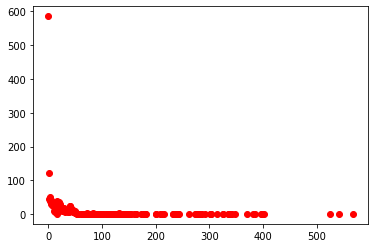

In [132]:
import collections
import matplotlib.pyplot as plt

print(G)

# All degrees
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = collections.Counter(degree_sequence)
degrees, counts = zip(*degree_count.items())


top_five = sorted(G.degree(), key=lambda x:x[1], reverse=True)[:50]
print("Top five ", top_five)
print()
print()
print()
# In degrees
degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)
degree_count = collections.Counter(degree_sequence)
in_degrees, in_counts = zip(*degree_count.items())

# Out degrees
degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)
degree_count = collections.Counter(degree_sequence)
out_degrees, out_counts = zip(*degree_count.items())

plt.plot(degrees, counts, 'ro')
plt.show()

# The graph is pretty correct, the only problem is that V and War and the two most popular characters: Because other's match V and War easily,

# PART 2

In [181]:
subgraphs = [G.subgraph(c) for c in nx.weakly_connected_components(G)]

# Probably not necessary to iterate
GCC = subgraphs[0]
print('aaa', type(GCC))
print(GCC)
for subgraph in subgraphs[1:]:
    if subgraph.number_of_nodes() > GCC.number_of_nodes():
        GCC = subgraph

print(GCC)
        
 # Universe attribute
attributes_dict = {}
for i in marvel_name_nodeLinks.keys():
    attributes_dict[i] = "dc"

for i in DC_name_nodeLinks.keys():
    attributes_dict[i] = "marvel"

nx.set_node_attributes(G, attributes_dict, name="universe")


aaa <class 'networkx.classes.digraph.DiGraph'>




In [175]:
GCC_undirected = GCC.to_undirected()
print(GCC_undirected)

In [ ]:
G